<a href="https://colab.research.google.com/github/nalgo-intern/team-a-2024-summer-08-26/blob/model/data_analyze.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#ライブラリ

In [ ]:
!pip install requests

In [ ]:
!pip install beautifulsoup4

In [ ]:
!pip install retry

In [ ]:
!pip install tqdm

In [ ]:
!pip install japanize-matplotlib

In [ ]:
!pip install --upgrade lightgbm

In [ ]:
import requests
from bs4 import BeautifulSoup
from retry import retry
import urllib
import time
import tqdm
import numpy as np
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
import japanize_matplotlib
from sklearn.preprocessing import LabelEncoder

#スクレイピング

In [ ]:
# 複数ページの情報をまとめて取得
data_list= []

# スクレイピングするページ数
max_page = 2000
# SUUMOを東京都23区のみ指定して検索して出力した画面のurl(ページ数フォーマットが必要)
#SUUMO
url = 'https://suumo.jp/jj/chintai/ichiran/FR301FC001/?ar=030&bs=040&ta=13&sc=13101&sc=13102&sc=13103&sc=13104&sc=13105&sc=13113&sc=13106&sc=13107&sc=13108&sc=13118&sc=13121&sc=13122&sc=13123&sc=13109&sc=13110&sc=13111&sc=13112&sc=13114&sc=13115&sc=13120&sc=13116&sc=13117&sc=13119&cb=0.0&ct=9999999&et=9999999&cn=9999999&mb=0&mt=9999999&shkr1=03&shkr2=03&shkr3=03&shkr4=03&fw2=&page={}'


# リクエストがうまく行かないパターンを回避するためのやり直し
@retry(tries=3, delay=10, backoff=2)
def load_page(url):
    html = requests.get(url)
    soup = BeautifulSoup(html.content, 'html.parser')
    return soup

In [ ]:
# ページごとの処理
start = time.time()
times = []
for page in range(1,max_page+1):
    before = time.time()
    # ページ情報
    soup = load_page(url.format(page))
    # 物件情報リストを指定
    mother = soup.find_all(class_='cassetteitem')

    # 物件ごとの処理
    for child in mother:

        # 建物情報
        data_home = []
        # カテゴリ
        data_home.append(child.find(class_='ui-pct ui-pct--util1').text)
        # 建物名
        data_home.append(child.find(class_='cassetteitem_content-title').text)
        # 住所
        data_home.append(child.find(class_='cassetteitem_detail-col1').text)
        # 最寄り駅のアクセス
        children = child.find(class_='cassetteitem_detail-col2')
        for id,grandchild in enumerate(children.find_all(class_='cassetteitem_detail-text')):
            data_home.append(grandchild.text)
        # 築年数と階数
        children = child.find(class_='cassetteitem_detail-col3')
        for grandchild in children.find_all('div'):
            data_home.append(grandchild.text)

        # 部屋情報
        rooms = child.find(class_='cassetteitem_other')
        for room in rooms.find_all(class_='js-cassette_link'):
            data_room = []

            # 部屋情報が入っている表を探索
            for id_, grandchild in enumerate(room.find_all('td')):
                # 階
                if id_ == 2:
                    data_room.append(grandchild.text.strip())
                # 家賃と管理費
                elif id_ == 3:
                    data_room.append(grandchild.find(class_='cassetteitem_other-emphasis ui-text--bold').text)
                    data_room.append(grandchild.find(class_='cassetteitem_price cassetteitem_price--administration').text)
                # 敷金と礼金
                elif id_ == 4:
                    data_room.append(grandchild.find(class_='cassetteitem_price cassetteitem_price--deposit').text)
                    data_room.append(grandchild.find(class_='cassetteitem_price cassetteitem_price--gratuity').text)
                # 間取りと面積
                elif id_ == 5:
                    data_room.append(grandchild.find(class_='cassetteitem_madori').text)
                    data_room.append(grandchild.find(class_='cassetteitem_menseki').text)
                # url
                # elif id_ == 8:
                #     get_url = grandchild.find(class_='js-cassette_link_href cassetteitem_other-linktext').get('href')
                #     abs_url = urllib.parse.urljoin(url,get_url)
                #     data_room.append(abs_url)
            # 物件情報と部屋情報をくっつける
            data_sample = data_home + data_room
            data_list.append(data_sample)

    # 1アクセスごとに1秒休む
    time.sleep(1)
    after = time.time()
    running_time = after - before
    times.append(running_time)
    print(f'{page}ページ目：{running_time}秒')
    # 取得した件数
    print(f'総取得件数：{len(data_list)}')
    # 作業進捗
    complete_ratio = round(page/max_page*100,3)
    print(f'完了：{complete_ratio}%')
    # 作業の残り時間目安を表示
    running_mean = np.mean(times)
    running_required_time = running_mean * (max_page - page)
    hour = int(running_required_time/3600)
    minute = int((running_required_time%3600)/60)
    second = int(running_required_time%60)
    print(f'残り時間：{hour}時間{minute}分{second}秒\n')

ストリーミング出力は最後の 5000 行に切り捨てられました。
1001ページ目：7.649747371673584秒
総取得件数：81860
完了：50.05%
残り時間：1時間56分2秒

1002ページ目：7.606488466262817秒
総取得件数：81934
完了：50.1%
残り時間：1時間55分55秒

1003ページ目：7.186603784561157秒
総取得件数：81990
完了：50.15%
残り時間：1時間55分48秒

1004ページ目：7.9093146324157715秒
総取得件数：82057
完了：50.2%
残り時間：1時間55分42秒

1005ページ目：7.095008373260498秒
総取得件数：82110
完了：50.25%
残り時間：1時間55分36秒

1006ページ目：6.984249114990234秒
総取得件数：82166
完了：50.3%
残り時間：1時間55分29秒

1007ページ目：7.26762843132019秒
総取得件数：82206
完了：50.35%
残り時間：1時間55分22秒

1008ページ目：7.172773122787476秒
総取得件数：82244
完了：50.4%
残り時間：1時間55分15秒

1009ページ目：7.420761585235596秒
総取得件数：82297
完了：50.45%
残り時間：1時間55分9秒

1010ページ目：7.129134893417358秒
総取得件数：82352
完了：50.5%
残り時間：1時間55分2秒

1011ページ目：7.549476146697998秒
総取得件数：82393
完了：50.55%
残り時間：1時間54分55秒

1012ページ目：7.4821977615356445秒
総取得件数：82475
完了：50.6%
残り時間：1時間54分49秒

1013ページ目：8.041656255722046秒
総取得件数：82521
完了：50.65%
残り時間：1時間54分43秒

1014ページ目：7.625726222991943秒
総取得件数：82575
完了：50.7%
残り時間：1時間54分37秒

1015ページ目：8.003881454467773秒
総取得件数：82655
完了：50.75%
残り時

In [ ]:
df = pd.DataFrame(data_list)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,賃貸マンション,アヴニール綾瀬,東京都葛飾区小菅４,ＪＲ常磐線/綾瀬駅 歩8分,京成本線/堀切菖蒲園駅 歩18分,東武伊勢崎線/小菅駅 歩21分,築13年,5階建,2階,12.3万円,7000円,12.3万円,12.3万円,1LDK,46.47m2
1,賃貸マンション,アヴニール綾瀬,東京都葛飾区小菅４,ＪＲ常磐線/綾瀬駅 歩8分,京成本線/堀切菖蒲園駅 歩18分,東武伊勢崎線/小菅駅 歩21分,築13年,5階建,5階,12.8万円,7000円,12.8万円,12.8万円,1LDK,47.52m2
2,賃貸マンション,東京メトロ日比谷線 三ノ輪駅 10階建 築20年,東京都荒川区南千住５,東京メトロ日比谷線/三ノ輪駅 歩4分,ＪＲ常磐線/南千住駅 歩9分,東京メトロ日比谷線/南千住駅 歩9分,築20年,10階建,3階,17万円,12000円,17万円,17万円,3LDK,69.83m2
3,賃貸マンション,プリムヴェール西尾久メゾンＣ,東京都荒川区西尾久８,ＪＲ高崎線/尾久駅 歩10分,ＪＲ京浜東北線/上中里駅 歩12分,東京メトロ南北線/西ケ原駅 歩21分,築18年,4階建,1階,14.4万円,9000円,14.4万円,28.8万円,3LDK,58.93m2
4,賃貸マンション,プリムヴェール西尾久メゾンＣ,東京都荒川区西尾久８,ＪＲ高崎線/尾久駅 歩10分,ＪＲ京浜東北線/上中里駅 歩12分,東京メトロ南北線/西ケ原駅 歩21分,築18年,4階建,4階,16万円,10000円,16万円,32万円,3SLDK,66.54m2


In [ ]:
df.to_csv('submission.csv',index=False)

#データ読み込み

In [ ]:
from google.colab import drive
import pandas as pd

# Google Driveをマウント
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import drive
import pandas as pd

# Google Driveをマウント
drive.mount('/content/drive')

# ファイルパスを指定してCSVファイルを読み込む
file_path = '/content/drive/MyDrive/Colab Notebooks/submission (2).csv'
df = pd.read_csv(file_path)

# データの表示
print(df.head())
df.shape

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
         0                         1           2                   3  \
0  賃貸マンション                   アヴニール綾瀬   東京都葛飾区小菅４       ＪＲ常磐線/綾瀬駅 歩8分   
1  賃貸マンション                   アヴニール綾瀬   東京都葛飾区小菅４       ＪＲ常磐線/綾瀬駅 歩8分   
2  賃貸マンション  東京メトロ日比谷線 三ノ輪駅 10階建 築20年  東京都荒川区南千住５  東京メトロ日比谷線/三ノ輪駅 歩4分   
3  賃貸マンション            プリムヴェール西尾久メゾンＣ  東京都荒川区西尾久８      ＪＲ高崎線/尾久駅 歩10分   
4  賃貸マンション            プリムヴェール西尾久メゾンＣ  東京都荒川区西尾久８      ＪＲ高崎線/尾久駅 歩10分   

                   4                   5     6     7   8       9      10  \
0   京成本線/堀切菖蒲園駅 歩18分     東武伊勢崎線/小菅駅 歩21分  築13年   5階建  2階  12.3万円   7000円   
1   京成本線/堀切菖蒲園駅 歩18分     東武伊勢崎線/小菅駅 歩21分  築13年   5階建  5階  12.8万円   7000円   
2     ＪＲ常磐線/南千住駅 歩9分  東京メトロ日比谷線/南千住駅 歩9分  築20年  10階建  3階    17万円  12000円   
3  ＪＲ京浜東北線/上中里駅 歩12分  東京メトロ南北線/西ケ原駅 歩21分  築18年   4階建  1階  14.4万円   9000円   
4  ＪＲ京浜東北線/上中里駅 歩12分  東京メトロ南北線/西ケ原駅 歩21分  築18年   4階建  4階  

(135362, 15)

#データ前処理

In [ ]:
df.columns = ['カテゴリ','建物名','住所', '最寄駅1', '最寄駅2', '最寄駅3', '築年数', '階数', '階', '賃料','管理費','敷金','礼金','間取り', '専有面積']

In [ ]:
df.replace('-', np.nan, inplace=True)
df['階数'].replace('地下3地上1階建', np.nan, inplace=True)



df_cleaned = df.dropna()

# インデックスを振り直す
df_cleaned = df_cleaned.reset_index(drop=True)

# 結果の表示
print(df_cleaned.shape)

(42872, 15)


In [ ]:
def preprocessing(df):
    df_new=df_cleaned.copy()


    wards=[]
    citys=[]
    lines=[]
    stations=[]
    distances=[]
    results=[]
    ages=[]
    builds=[]
    Floors=[]
    prices=[]
    kanrihis=[]
    sikikins=[]
    reikins=[]
    areas=[]

    for i in range(0,len(df_new)):
        ###住所を'23区'、'都市名'に分ける
        pattern='.*区'
        repatter = re.compile(pattern)
        result = repatter.match(df['住所'][i])
        wards.append(result.group()[3:])
        citys.append(df_new['住所'][i].split('区')[1])

        access=df_new['最寄駅1'][i]

        #路線
        line=access.split('/')[0]

        #駅と徒歩
        station_distance=access.split('/')[1]

        #駅
        station=re.findall(r'.*駅', station_distance)

        #徒歩
        distance=re.findall(r'\d+',access)

        lines.append(line)
        if len(station)==1:
            stations.append(station[0])
        else:
            stations.append(station_distance.split(' ')[0])

        distances.append(int(distance[0]))


        ###築年数はint型に変換
        age=df_new['築年数']
        if age[i][0]=='新':
            ages.append(0)
        else:
            ages.append(int(age[i].split('年')[0][1:]))

        ###構造
        m=re.findall(r'\d+', df_new['階数'][i])
        if len(m)==1:
            builds.append(int(m[0]))
        elif len(m)==2:
            builds.append(int(m[1]))
        else:
            builds.append(1)

        ###部屋の階数
        floor=df_new['階'][i]
        f=re.findall(r'\d+',floor)

        if len(f)==1:
            Floors.append(int(f[0]))
        else:
            Floors.append(np.random.randint(1,int(builds[i])))

        ###賃料
        price=df_new['賃料']
        prices.append(float(price[i].split('万')[0])*10000)

        ###管理費
        kanrihi=df_new['管理費']
        if kanrihi[i]!='-':
            kanrihis.append(int(kanrihi[i].split('円')[0]))
        else:
            kanrihis.append(float(0))

        ###敷金
        sikikin=df_new['敷金']
        if sikikin[i]!='-':
            sikikins.append(float(sikikin[i].split('万')[0])*10000)
        else:
            sikikins.append(float(0))

        ###礼金
        reikin=df_new['礼金']
        if reikin[i]!='-':
            reikins.append(float(reikin[i].split('万')[0])*10000)
        else:
            reikins.append(float(0))

        ###面積
        area=df_new['専有面積']
        areas.append(float(area[i].split('m')[0]))


    ###変換したカラムの追加
    df_new['23区']=wards
    df_new['都市名']=citys
    df_new['路線']=lines
    df_new['最寄駅']=stations
    df_new['徒歩']=distances
    df_new['築年数']=ages
    df_new['階数']=builds
    df_new['階']=Floors
    df_new['賃料']=prices
    df_new['管理費']=kanrihis
    df_new['敷金']=sikikins
    df_new['礼金']=reikins
    df_new['専有面積']=areas

    ###不要なカラムを削除
    df_new=df_new.drop('住所',axis=1)
    df_new=df_new.drop(['最寄駅1', '最寄駅2', '最寄駅3'],axis=1)

    return df_new

df_new=preprocessing(df)
df_new.head()


,カテゴリ,建物名,築年数,階数,階,賃料,管理費,敷金,礼金,間取り,専有面積,23区,都市名,路線,最寄駅,徒歩
0,賃貸マンション,アヴニール綾瀬,13,5,2,123000.0,7000,123000.0,123000.0,1LDK,46.47,葛飾区,小菅４,ＪＲ常磐線,綾瀬駅,8
1,賃貸マンション,アヴニール綾瀬,13,5,5,128000.0,7000,128000.0,128000.0,1LDK,47.52,葛飾区,小菅４,ＪＲ常磐線,綾瀬駅,8
2,賃貸マンション,東京メトロ日比谷線 三ノ輪駅 10階建 築20年,20,10,3,170000.0,12000,170000.0,170000.0,3LDK,69.83,荒川区,南千住５,東京メトロ日比谷線,三ノ輪駅,4
3,賃貸マンション,プリムヴェール西尾久メゾンＣ,18,4,1,144000.0,9000,144000.0,288000.0,3LDK,58.93,荒川区,西尾久８,ＪＲ高崎線,尾久駅,10
4,賃貸マンション,プリムヴェール西尾久メゾンＣ,18,4,4,160000.0,10000,160000.0,320000.0,3SLDK,66.54,荒川区,西尾久８,ＪＲ高崎線,尾久駅,10


#データ分析

In [ ]:
selected_data = (df_new[['23区','築年数', '階数', '階', '賃料','管理費','間取り','敷金','礼金','専有面積','最寄駅']])
selected_data

,23区,築年数,階数,階,賃料,管理費,間取り,敷金,礼金,専有面積,最寄駅
0,葛飾区,13,5,2,123000.0,7000,1LDK,123000.0,123000.0,46.47,綾瀬駅
1,葛飾区,13,5,5,128000.0,7000,1LDK,128000.0,128000.0,47.52,綾瀬駅
2,荒川区,20,10,3,170000.0,12000,3LDK,170000.0,170000.0,69.83,三ノ輪駅
3,荒川区,18,4,1,144000.0,9000,3LDK,144000.0,288000.0,58.93,尾久駅
4,荒川区,18,4,4,160000.0,10000,3SLDK,160000.0,320000.0,66.54,尾久駅
...,...,...,...,...,...,...,...,...,...,...,...
42867,中央区,29,3,3,95000.0,5000,1LDK,95000.0,95000.0,45.10,扇大橋駅
42868,中央区,29,3,2,110000.0,5000,2LDK,110000.0,110000.0,58.44,扇大橋駅
42869,中央区,30,3,3,116000.0,4000,2LDK,116000.0,116000.0,64.53,篠崎駅
42870,中央区,0,4,2,198000.0,8000,2LDK,198000.0,396000.0,59.87,椎名町駅


In [ ]:
le = LabelEncoder()
selected_data['23区_label'] = le.fit_transform(selected_data['23区'])
selected_data['最寄駅_label'] = le.fit_transform(selected_data['最寄駅'])

<ipython-input-37-7399461ac8b2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_data['23区_label'] = le.fit_transform(selected_data['23区'])
<ipython-input-37-7399461ac8b2>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_data['最寄駅_label'] = le.fit_transform(selected_data['最寄駅'])


In [ ]:
selected_data['賃料_管理費合計'] = selected_data['賃料'] + selected_data['管理費']

<ipython-input-38-4b3be7cd061b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_data['賃料_管理費合計'] = selected_data['賃料'] + selected_data['管理費']


In [ ]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

# OneHotEncoderのインスタンス作成
encoder = OneHotEncoder(sparse=False, drop='first')
encoded_features = encoder.fit_transform(selected_data[['23区']])

# エンコードされた特徴量をデータフレームに変換
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(['23区']))

# 元のデータフレームとエンコードされたデータフレームを結合
df_encoded = pd.concat([selected_data.drop('23区', axis=1), encoded_df], axis=1)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
df_encoded

,築年数,階数,階,賃料,管理費,間取り,敷金,礼金,専有面積,間取り_label,...,23区_江戸川区,23区_江東区,23区_渋谷区,23区_港区,23区_目黒区,23区_練馬区,23区_荒川区,23区_葛飾区,23区_豊島区,23区_足立区
0,13,5,2,123000.0,7000,1LDK,123000.0,123000.0,46.47,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,13,5,5,128000.0,7000,1LDK,128000.0,128000.0,47.52,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,20,10,3,170000.0,12000,3LDK,170000.0,170000.0,69.83,17,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,18,4,1,144000.0,9000,3LDK,144000.0,288000.0,58.93,17,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,18,4,4,160000.0,10000,3SLDK,160000.0,320000.0,66.54,19,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42867,29,3,3,95000.0,5000,1LDK,95000.0,95000.0,45.10,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42868,29,3,2,110000.0,5000,2LDK,110000.0,110000.0,58.44,11,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42869,30,3,3,116000.0,4000,2LDK,116000.0,116000.0,64.53,11,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42870,0,4,2,198000.0,8000,2LDK,198000.0,396000.0,59.87,11,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
selected_data.to_csv('0829_train.csv',index=False)
df_encoded.to_csv('0829_2_train.csv',index=False)

In [ ]:
selected_data

,23区,築年数,階数,階,賃料,管理費,間取り,敷金,礼金,専有面積,間取り_label,部屋数,LDK,S,23区_label,賃料_管理費合計
0,葛飾区,13,5,2,123000.0,7000,1LDK,123000.0,123000.0,46.47,2,1,3,0,20,130000.0
1,葛飾区,13,5,5,128000.0,7000,1LDK,128000.0,128000.0,47.52,2,1,3,0,20,135000.0
2,荒川区,20,10,3,170000.0,12000,3LDK,170000.0,170000.0,69.83,17,3,3,0,19,182000.0
3,荒川区,18,4,1,144000.0,9000,3LDK,144000.0,288000.0,58.93,17,3,3,0,19,153000.0
4,荒川区,18,4,4,160000.0,10000,3SLDK,160000.0,320000.0,66.54,19,3,3,1,19,170000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42867,中央区,29,3,3,95000.0,5000,1LDK,95000.0,95000.0,45.10,2,1,3,0,1,100000.0
42868,中央区,29,3,2,110000.0,5000,2LDK,110000.0,110000.0,58.44,11,2,3,0,1,115000.0
42869,中央区,30,3,3,116000.0,4000,2LDK,116000.0,116000.0,64.53,11,2,3,0,1,120000.0
42870,中央区,0,4,2,198000.0,8000,2LDK,198000.0,396000.0,59.87,11,2,3,0,1,206000.0


<Figure size 3000x1000 with 0 Axes>

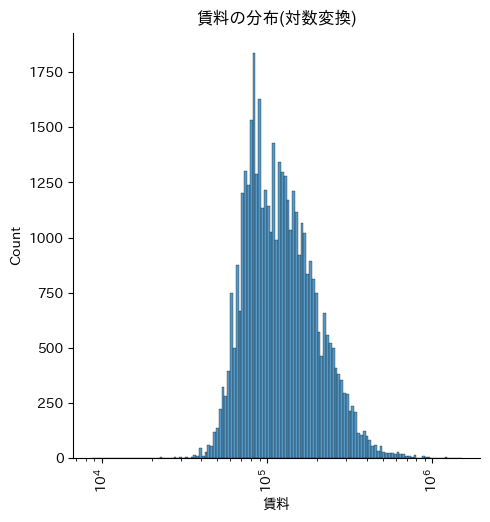

In [ ]:
plt.figure(figsize=(30, 10))
sns.displot(data=selected_data, x= "賃料", log_scale = 10)
plt.tick_params(axis="x", rotation=90)
plt.title('賃料の分布(対数変換)')
plt.show()

<Figure size 3000x1000 with 0 Axes>

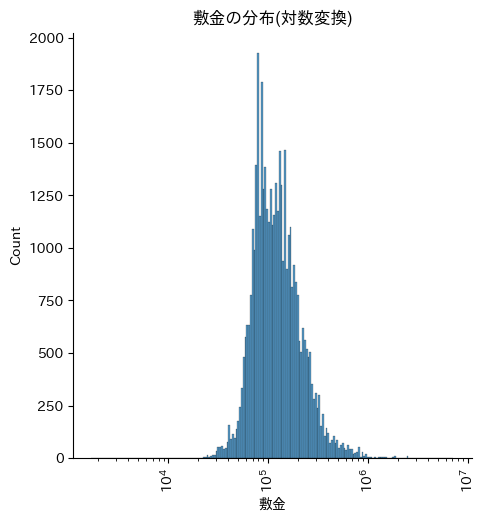

In [ ]:
plt.figure(figsize=(30, 10))
sns.displot(data=selected_data, x= "敷金", log_scale = 10)
plt.tick_params(axis="x", rotation=90)
plt.title('敷金の分布(対数変換)')
plt.show()

<ipython-input-14-575c30aab732>:13: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


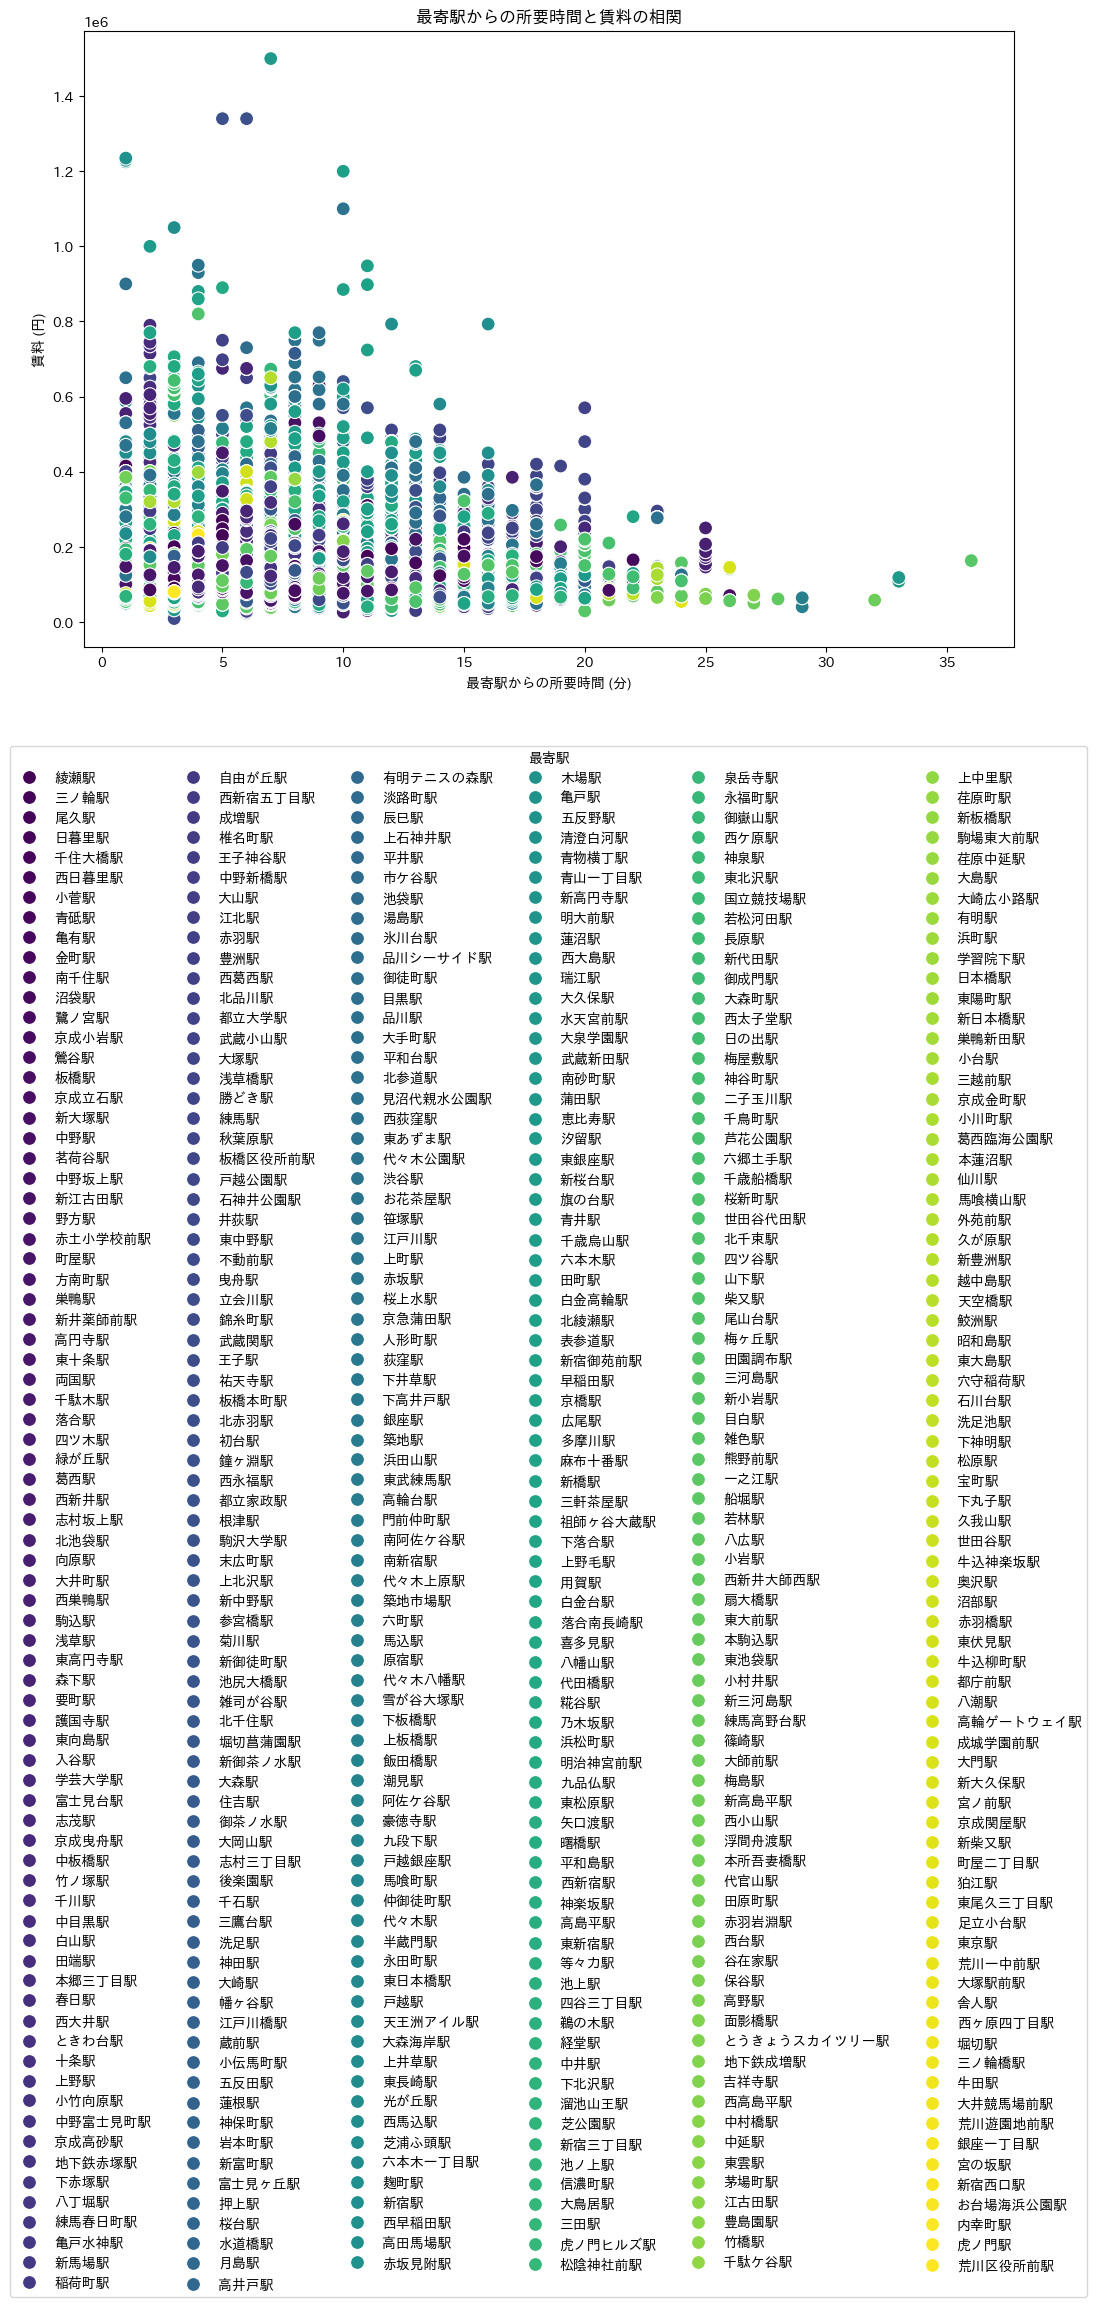

In [ ]:
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df_new, x='徒歩', y='賃料', hue='最寄駅', palette='viridis', s=100)


plt.title('最寄駅からの所要時間と賃料の相関')
plt.xlabel('最寄駅からの所要時間 (分)')
plt.ylabel('賃料 (円)')


plt.legend(title='最寄駅', bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=6)


plt.tight_layout()
plt.show()


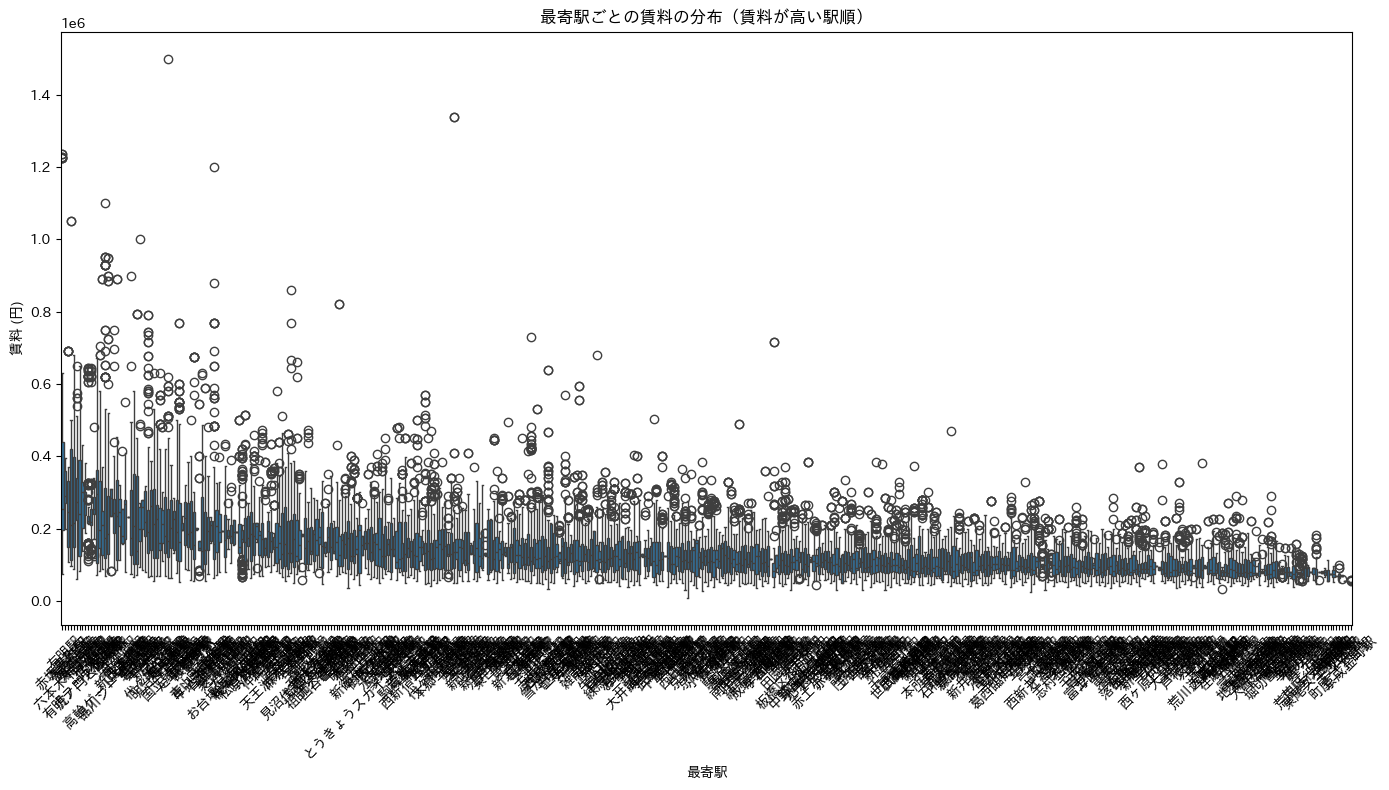

賃料が高い駅 TOP10 ['赤坂見附駅', '有明駅', '大手町駅', '六本木一丁目駅', '表参道駅', '勝どき駅', '外苑前駅', '新豊洲駅', '有明テニスの森駅', '神谷町駅']


In [ ]:

# 最寄駅ごとに賃料の平均
mean_rent_by_station = df_new.groupby('最寄駅')['賃料'].mean().reset_index()
mean_rent_by_station = mean_rent_by_station.sort_values(by='賃料', ascending=False)

# ソートされた最寄駅のリスト作成
sorted_stations = mean_rent_by_station['最寄駅'].tolist()

# DataFrameを最寄駅の順序でソート
df_new['最寄駅'] = pd.Categorical(df_new['最寄駅'], categories=sorted_stations, ordered=True)
df_sorted = df_new.sort_values('最寄駅')


plt.figure(figsize=(14, 8))
sns.boxplot(data=df_sorted, x='最寄駅', y='賃料')


plt.title('最寄駅ごとの賃料の分布（賃料が高い駅順）')
plt.xlabel('最寄駅')
plt.ylabel('賃料 (円)')


plt.xticks(rotation=45)
plt.tight_layout()


plt.show()
print('賃料が高い駅 TOP10', sorted_stations[:10])

<ipython-input-16-decee73572be>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=station_counts, x='最寄駅', y='カウント', palette='viridis')


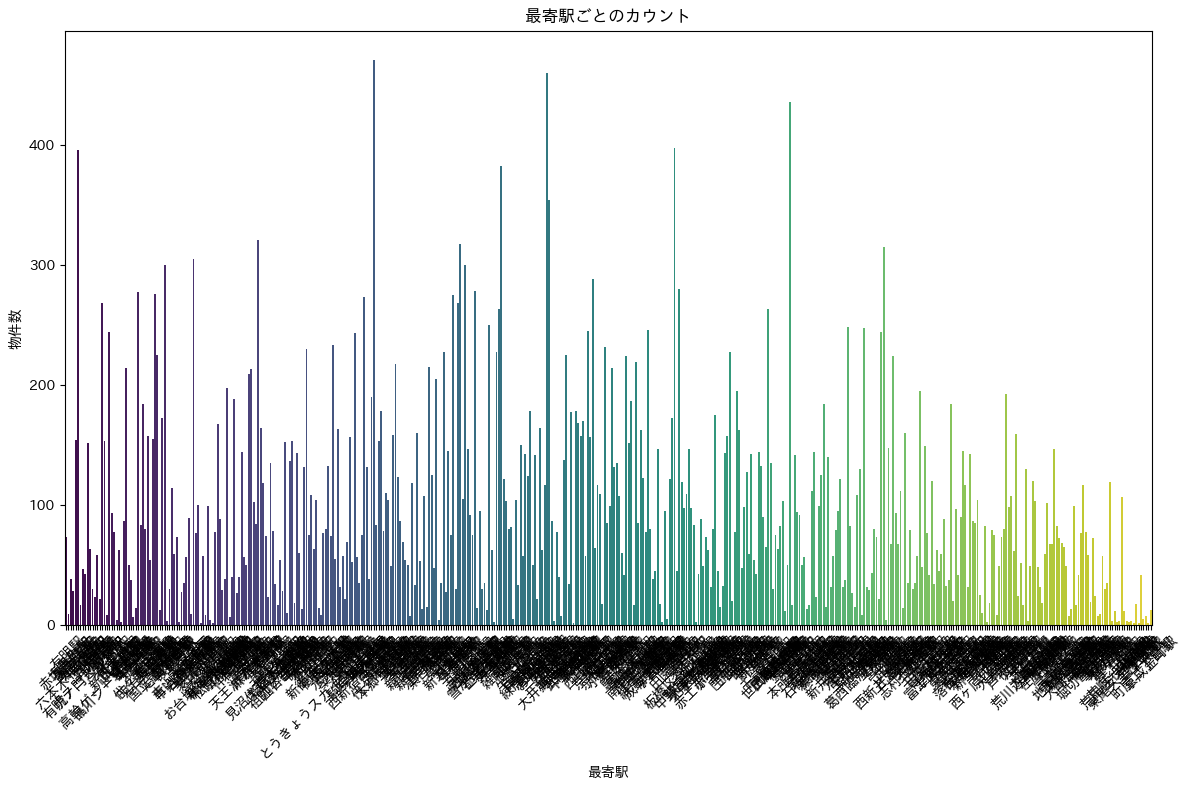

駅周辺の物件数 TOP10
      最寄駅  カウント
0    大塚駅   471
1  三軒茶屋駅   460
2   高円寺駅   436
3    荻窪駅   397
4   勝どき駅   396
5    浅草駅   382
6   北千住駅   354
7  麻布十番駅   321
8    池袋駅   317
9    大森駅   315


In [ ]:

station_counts = df_sorted['最寄駅'].value_counts().reset_index()
station_counts.columns = ['最寄駅', 'カウント']


plt.figure(figsize=(12, 8))
sns.barplot(data=station_counts, x='最寄駅', y='カウント', palette='viridis')


plt.title('最寄駅ごとのカウント')
plt.xlabel('最寄駅')
plt.ylabel('物件数')

plt.xticks(rotation=45)
plt.tight_layout()

plt.show()
print('駅周辺の物件数 TOP10\n', station_counts.head(10))

<ipython-input-17-1b7a71f639cf>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_new, x='間取り', y='賃料', palette='viridis')


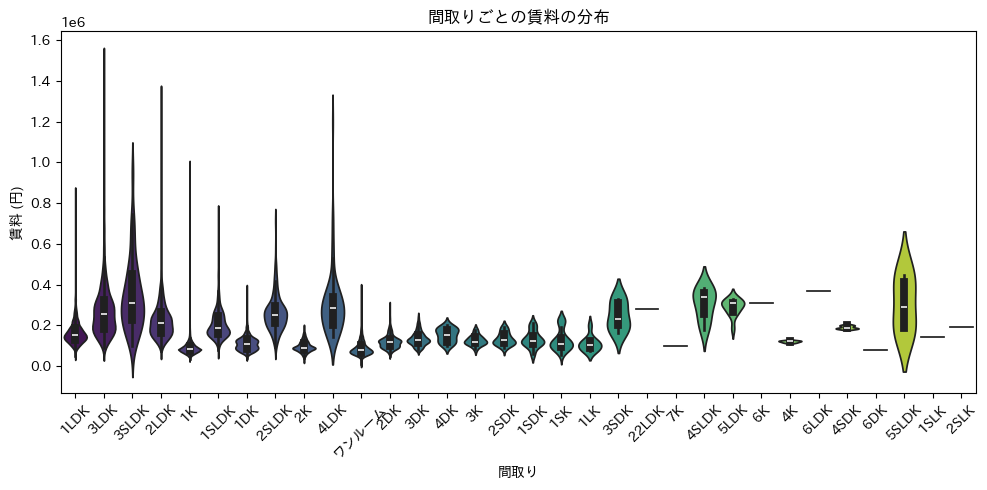

In [ ]:
plt.figure(figsize=(10, 5))
sns.violinplot(data=df_new, x='間取り', y='賃料', palette='viridis')


plt.title('間取りごとの賃料の分布')
plt.xlabel('間取り')
plt.ylabel('賃料 (円)')


plt.xticks(rotation=45)
plt.tight_layout()


plt.show()


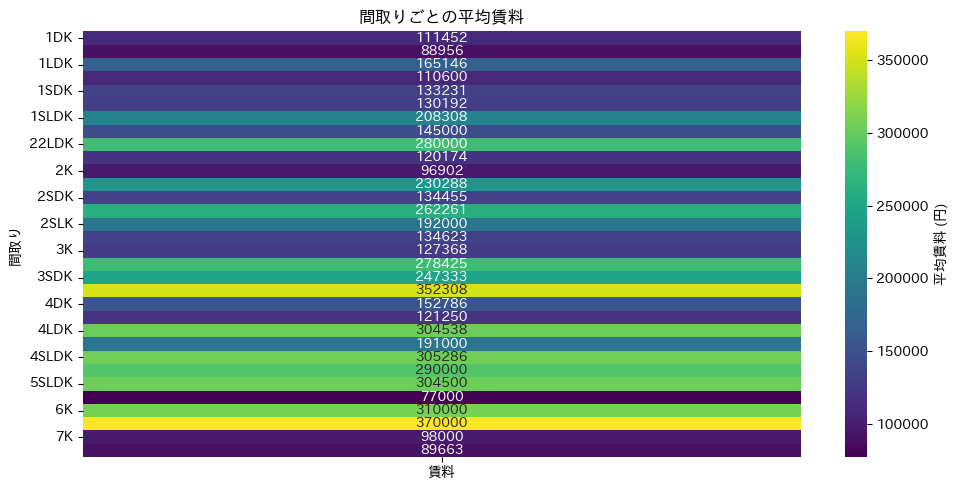

In [ ]:
heatmap_data = df_new.pivot_table(index='間取り', values='賃料', aggfunc='mean')

plt.figure(figsize=(10, 5))
sns.heatmap(heatmap_data, annot=True, cmap='viridis', fmt='.0f', cbar_kws={'label': '平均賃料 (円)'})

plt.title('間取りごとの平均賃料')

plt.tight_layout()
plt.show()

<ipython-input-19-3b149ddc39a4>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=madori_counts, x='間取り', y='カウント', palette='viridis')


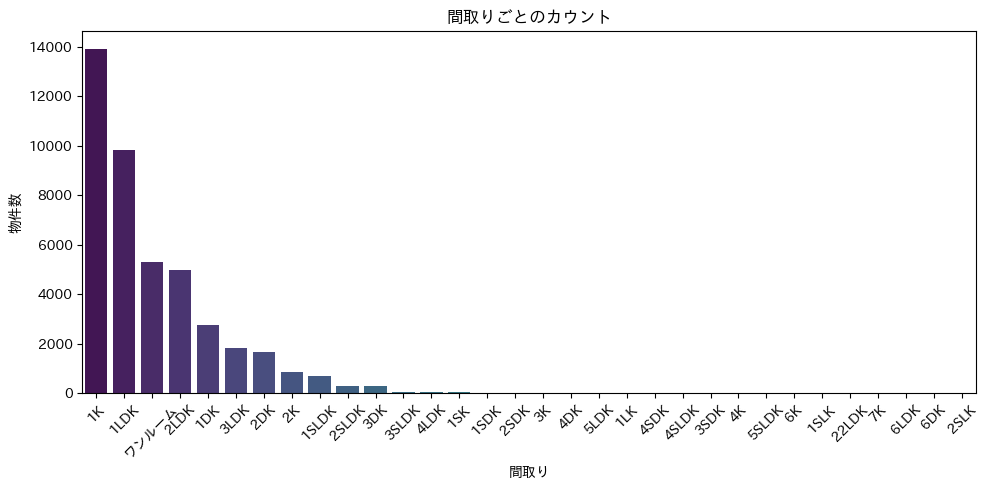

間取りごとの物件数 TOP10
      間取り   カウント
0     1K  13920
1   1LDK   9837
2  ワンルーム   5293
3   2LDK   4980
4    1DK   2767
5   3LDK   1855
6    2DK   1689
7     2K    871
8  1SLDK    702
9  2SLDK    310


In [ ]:
madori_counts = df_new['間取り'].value_counts().reset_index()
madori_counts.columns = ['間取り', 'カウント']

# 棒グラフの作成
plt.figure(figsize=(10, 5))
sns.barplot(data=madori_counts, x='間取り', y='カウント', palette='viridis')

# グラフのタイトルとラベル
plt.title('間取りごとのカウント')
plt.xlabel('間取り')
plt.ylabel('物件数')

plt.xticks(rotation=45)
plt.tight_layout()

plt.show()
print('間取りごとの物件数 TOP10\n', madori_counts.head(10))

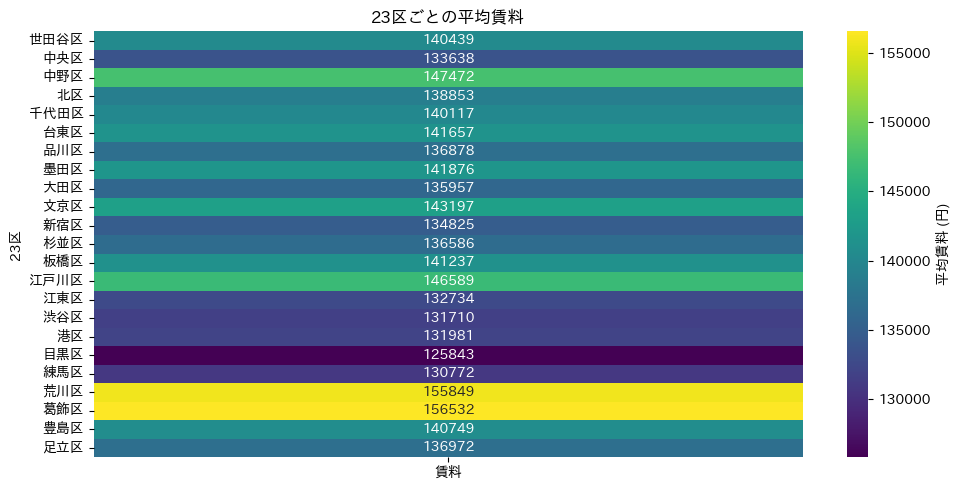

In [ ]:

heatmap_data = df_new.pivot_table(index='23区', values='賃料', aggfunc='mean')


plt.figure(figsize=(10, 5))
sns.heatmap(heatmap_data, annot=True, cmap='viridis', fmt='.0f', cbar_kws={'label': '平均賃料 (円)'})

plt.title('23区ごとの平均賃料')

plt.tight_layout()
plt.show()

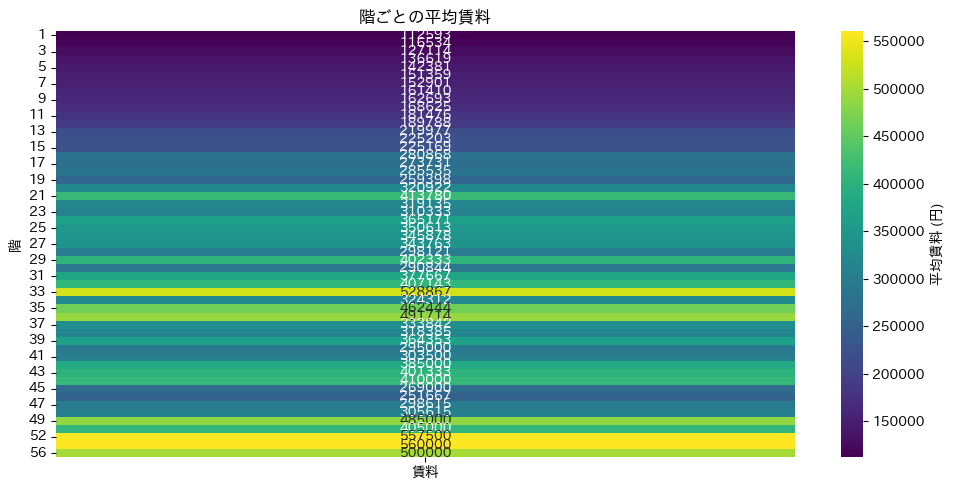

In [ ]:

heatmap_data = df_new.pivot_table(index='階', values='賃料', aggfunc='mean')


plt.figure(figsize=(10, 5))
sns.heatmap(heatmap_data, annot=True, cmap='viridis', fmt='.0f', cbar_kws={'label': '平均賃料 (円)'})

plt.title('階ごとの平均賃料')

plt.tight_layout()
plt.show()

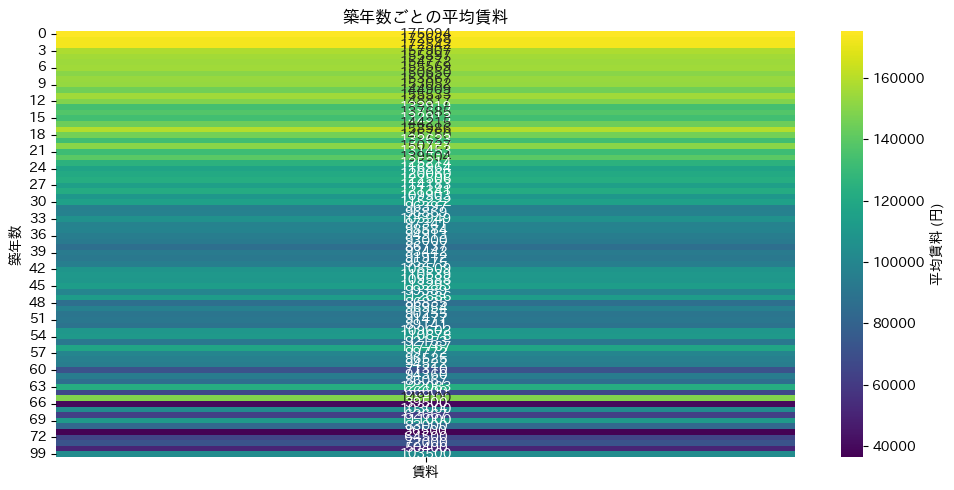

In [ ]:
heatmap_data = df_new.pivot_table(index='築年数', values='賃料', aggfunc='mean')


plt.figure(figsize=(10, 5))
sns.heatmap(heatmap_data, annot=True, cmap='viridis', fmt='.0f', cbar_kws={'label': '平均賃料 (円)'})

# グラフのタイトル
plt.title('築年数ごとの平均賃料')

# グラフを表示
plt.tight_layout()
plt.show()

<ipython-input-22-e5cb69adeb63>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=chikunen_counts, x='築年数', y='カウント', palette='viridis')


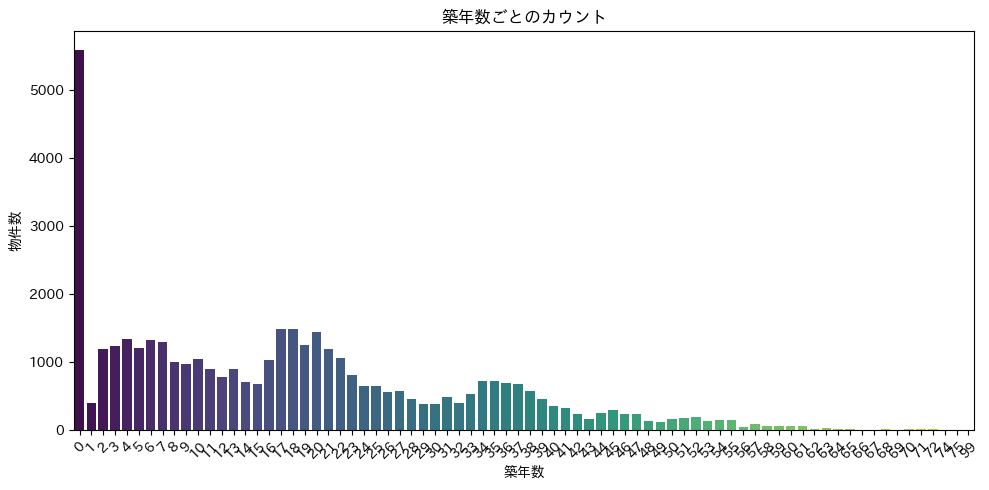

築年数ごとの物件数 TOP10
    築年数  カウント
0    0  5586
1   18  1484
2   17  1480
3   20  1433
4    4  1330
5    6  1326
6    7  1293
7   19  1244
8    3  1236
9    5  1200


In [ ]:
chikunen_counts = df_new['築年数'].value_counts().reset_index()
chikunen_counts.columns = ['築年数', 'カウント']

# 棒グラフの作成
plt.figure(figsize=(10, 5))
sns.barplot(data=chikunen_counts, x='築年数', y='カウント', palette='viridis')

# グラフのタイトルとラベル
plt.title('築年数ごとのカウント')
plt.xlabel('築年数')
plt.ylabel('物件数')

plt.xticks(rotation=45)
plt.tight_layout()

plt.show()
print('築年数ごとの物件数 TOP10\n', chikunen_counts.head(10))

#特徴量エンジニアリング

In [ ]:
le = LabelEncoder()
selected_data['間取り_label'] = le.fit_transform(selected_data['間取り'])

# 元の値とラベルの対応関係を表示
label_mapping = pd.DataFrame({
    '元の値': le.classes_,
    'ラベル': range(len(le.classes_))
})

print(label_mapping)


# 部屋数、LDK数、Sの有無を特徴量として追加
# ワンルームは部屋数を1に設定
selected_data['部屋数'] = selected_data['間取り'].apply(lambda x: 1 if 'ワンルーム' in x else int(x[0]) if x[0].isdigit() else 0)
selected_data['LDK'] = selected_data['間取り'].apply(lambda x: sum([x.count(c) for c in 'LDK']))
selected_data['S'] = selected_data['間取り'].apply(lambda x: 1 if 'S' in x else 0)


      元の値  ラベル
0     1DK    0
1      1K    1
2    1LDK    2
3     1LK    3
4    1SDK    4
5     1SK    5
6   1SLDK    6
7    1SLK    7
8   22LDK    8
9     2DK    9
10     2K   10
11   2LDK   11
12   2SDK   12
13  2SLDK   13
14   2SLK   14
15    3DK   15
16     3K   16
17   3LDK   17
18   3SDK   18
19  3SLDK   19
20    4DK   20
21     4K   21
22   4LDK   22
23   4SDK   23
24  4SLDK   24
25   5LDK   25
26  5SLDK   26
27    6DK   27
28     6K   28
29   6LDK   29
30     7K   30
31  ワンルーム   31


In [ ]:
selected_data

,23区,築年数,階数,階,賃料,管理費,間取り,敷金,礼金,専有面積,最寄駅,23区_label,最寄駅_label,賃料_管理費合計,間取り_label,部屋数,LDK,S
0,葛飾区,13,5,2,123000.0,7000,1LDK,123000.0,123000.0,46.47,綾瀬駅,20,344,130000.0,2,1,3,0
1,葛飾区,13,5,5,128000.0,7000,1LDK,128000.0,128000.0,47.52,綾瀬駅,20,344,135000.0,2,1,3,0
2,荒川区,20,10,3,170000.0,12000,3LDK,170000.0,170000.0,69.83,三ノ輪駅,19,6,182000.0,17,3,3,0
3,荒川区,18,4,1,144000.0,9000,3LDK,144000.0,288000.0,58.93,尾久駅,19,159,153000.0,17,3,3,0
4,荒川区,18,4,4,160000.0,10000,3SLDK,160000.0,320000.0,66.54,尾久駅,19,159,170000.0,19,3,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42867,中央区,29,3,3,95000.0,5000,1LDK,95000.0,95000.0,45.10,扇大橋駅,1,185,100000.0,2,1,3,0
42868,中央区,29,3,2,110000.0,5000,2LDK,110000.0,110000.0,58.44,扇大橋駅,1,185,115000.0,11,2,3,0
42869,中央区,30,3,3,116000.0,4000,2LDK,116000.0,116000.0,64.53,篠崎駅,1,341,120000.0,11,2,3,0
42870,中央区,0,4,2,198000.0,8000,2LDK,198000.0,396000.0,59.87,椎名町駅,1,266,206000.0,11,2,3,0


In [ ]:
selected_data.to_csv('0829_train.csv',index=False)

#実装

##ライブラリ

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error,  r2_score

##機械学習モデルの作成

In [ ]:
from google.colab import drive
import pandas as pd

# Google Driveをマウント
drive.mount('/content/drive')

# ファイルパスを指定してCSVファイルを読み込む
file_path = '/content/train.csv'
train= pd.read_csv(file_path)

# データの表示
print(train.head())
train.shape

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
   築年数  階数  階        賃料    管理費    間取り        敷金        礼金   専有面積  間取り_label  \
0   13   5  2  123000.0   7000   1LDK  123000.0  123000.0  46.47          2   
1   13   5  5  128000.0   7000   1LDK  128000.0  128000.0  47.52          2   
2   20  10  3  170000.0  12000   3LDK  170000.0  170000.0  69.83         17   
3   18   4  1  144000.0   9000   3LDK  144000.0  288000.0  58.93         17   
4   18   4  4  160000.0  10000  3SLDK  160000.0  320000.0  66.54         19   

   部屋数  LDK  S  
0    1    3  0  
1    1    3  0  
2    3    3  0  
3    3    3  0  
4    3    3  1  


(42872, 13)

In [ ]:
features = ['築年数', '階数', '階', '管理費', '敷金', '礼金', '専有面積', '間取り_label', '部屋数', 'LDK', 'S']

In [ ]:
target = '賃料'

X = train[features]
y = train[target]

In [ ]:
print(np.shape(X))
print(np.shape(y))

(42872, 11)
(42872,)


In [ ]:
#標準化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
# トレーニングデータとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# LightGBMのデータセットを作成
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# LightGBMのハイパーパラメータ設定
params = {
    'objective': 'regression',
    'metric': 'mae',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}

In [ ]:
# モデルのトレーニング
model = lgb.train(params, train_data, num_boost_round=1000, valid_sets=[test_data])

# 予測
y_pred = model.predict(X_test, num_iteration=model.best_iteration)


# モデルの評価
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.119584 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1117
[LightGBM] [Info] Number of data points in the train set: 30010, number of used features: 11
[LightGBM] [Info] Start training from score 138209.676774
Mean Absolute Error: 1776.002240429221


In [ ]:
# モデルの評価
model_mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# ベースラインモデルの評価 (平均値モデル)
baseline_pred = [y_train.mean()] * len(y_test)
baseline_mae = mean_absolute_error(y_test, baseline_pred)


# 精度
percentage = 100 * (1 - model_mae / baseline_mae)
print(f'Model MAE: {model_mae}')
print(f'Baseline MAE: {baseline_mae}')
print(f'Performance Percentage: {percentage:.2f}%')
print(f'R² (Coefficient of Determination): {r2:.4f}')

Model MAE: 1776.002240429221
Baseline MAE: 58428.67671435495
Performance Percentage: 96.96%
R² (Coefficient of Determination): 0.9902
